In [82]:
import logging

import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import anndata
import squidpy as sq
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from umap import UMAP

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [3]:
adata = sc.read_h5ad('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/downstream_analysis/spatial_analysis.h5ad')
adata

2022-05-06 10:37:35,967 : DEBUG : Creating converter from 3 to 5


AnnData object with n_obs × n_vars = 221081 × 17
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3 intensity max', 'CD36 intensity max', 'HIF1a intensity max', 'GLUT1 intensity max', 'GATA3 intensity max', 'CD45RO intensity max', 'CD45RA intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'Maspin intensity max', 'Foxp3 intensity max', 'MMP9 intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'CD44 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min

#### Latent Dirichlet Allocation (LDA)

methods from https://www.biorxiv.org/content/10.1101/2021.05.23.445310v2.full

In [4]:
def cell_to_neighbors(adata, radius=50):
    X = adata.obs[['centroid_row', 'centroid_col']].values
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
    g = nbrs.radius_neighbors_graph(X, radius=radius)
    rows, cols, _ = scipy.sparse.find(g)
    
    cell_to_neighbhors = {}
    for r, c in zip(rows, cols):
        cid = adata.obs.index[r]
        if cid not in cell_to_neighbhors:
            cell_to_neighbhors[cid] = []
        else:
            cell_to_neighbhors[cid].append(adata.obs.index[c])
            
    return cell_to_neighbhors

In [5]:
cell_to_nbhrs = cell_to_neighbors(adata, radius=50)

In [6]:
cell_to_cell_type = {c:ct for c, ct in zip(adata.obs.index, adata.obs['cell_type'])}
docs = [[cell_to_cell_type[neighbor] for neighbor in cell_to_nbhrs[cell_id]]
        for cell_id in adata.obs.index.to_list()]
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

2022-05-06 10:37:46,400 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2022-05-06 10:37:46,467 : INFO : adding document #10000 to Dictionary<9 unique tokens: ['Malignant', 'CD4 T cell', 'Fibroblast', 'Macrophage', 'CD8 T cell']...>
2022-05-06 10:37:46,542 : INFO : adding document #20000 to Dictionary<9 unique tokens: ['Malignant', 'CD4 T cell', 'Fibroblast', 'Macrophage', 'CD8 T cell']...>
2022-05-06 10:37:46,616 : INFO : adding document #30000 to Dictionary<9 unique tokens: ['Malignant', 'CD4 T cell', 'Fibroblast', 'Macrophage', 'CD8 T cell']...>
2022-05-06 10:37:46,685 : INFO : adding document #40000 to Dictionary<9 unique tokens: ['Malignant', 'CD4 T cell', 'Fibroblast', 'Macrophage', 'CD8 T cell']...>
2022-05-06 10:37:46,752 : INFO : adding document #50000 to Dictionary<9 unique tokens: ['Malignant', 'CD4 T cell', 'Fibroblast', 'Macrophage', 'CD8 T cell']...>
2022-05-06 10:37:46,821 : INFO : adding document #60000 to Dictionary<9 unique tokens: ['Malignant', 'CD4 T 

In [7]:
len(dictionary), len(corpus)

(9, 221081)

In [8]:
num_topics = 10
chunksize = len(corpus)
passes = 5
iterations = 100
eval_every = None # turn this on to see how well everything is converging. off by default bc is takes time

In [9]:
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2022-05-06 10:37:49,086 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2022-05-06 10:37:49,087 : INFO : using serial LDA version on this node
2022-05-06 10:37:49,088 : INFO : running online (multi-pass) LDA training, 10 topics, 5 passes over the supplied corpus of 221081 documents, updating model once every 221081 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2022-05-06 10:37:49,089 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2022-05-06 10:37:49,100 : INFO : PROGRESS: pass 0, at document #221081/221081
2022-05-06 10:37:49,101 : DEBUG : performing inference on a chunk of 221081 documents
2022-05-06 10:39:09,508 : DEBUG : 218595/221081 documents converged within 100 iterations
2022-05-06 10:39:10,024 : INFO : optimized alpha [0.066873804, 0.07520923, 0.06682499, 0.07338981, 0.072008416, 0.0

2022-05-06 10:41:46,042 : INFO : topic #9 (0.059): 0.438*"Endothelial" + 0.378*"Fibroblast" + 0.078*"CD4 T cell" + 0.068*"CD8 T cell" + 0.030*"Macrophage" + 0.005*"DC" + 0.001*"B cell" + 0.001*"Malignant" + 0.000*"Myoepithelial"
2022-05-06 10:41:46,043 : INFO : topic #3 (0.061): 0.591*"Macrophage" + 0.204*"Fibroblast" + 0.099*"CD4 T cell" + 0.069*"Endothelial" + 0.017*"Malignant" + 0.008*"DC" + 0.007*"CD8 T cell" + 0.005*"B cell" + 0.000*"Myoepithelial"
2022-05-06 10:41:46,044 : INFO : topic #7 (0.212): 0.969*"Malignant" + 0.023*"Fibroblast" + 0.007*"Macrophage" + 0.001*"Endothelial" + 0.000*"CD4 T cell" + 0.000*"CD8 T cell" + 0.000*"Myoepithelial" + 0.000*"B cell" + 0.000*"DC"
2022-05-06 10:41:46,044 : INFO : topic diff=0.218297, rho=0.408248
2022-05-06 10:41:46,053 : DEBUG : starting a new internal lifecycle event log for LdaModel
2022-05-06 10:41:46,053 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel<num_terms=9, num_topics=10, decay=0.5, chunksize=221081> in 236.96s', '

In [10]:
top_topics = model.top_topics(corpus)
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics

2022-05-06 10:41:46,063 : DEBUG : Setting topics to those of the model: LdaModel<num_terms=9, num_topics=10, decay=0.5, chunksize=221081>
2022-05-06 10:41:46,070 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2022-05-06 10:41:46,073 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2022-05-06 10:41:46,077 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2022-05-06 10:41:46,080 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2022-05-06 10:41:46,083 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2022-05-06 10:41:46,087 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2022-05-06 10:41:46,090 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2022-05-06 10:41:46,094 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2022-05-06 10:41:46,097 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2022-05-06 10:41:46,100 : INFO : CorpusAccumulator accumulate

2022-05-06 10:41:46,371 : INFO : CorpusAccumulator accumulated stats from 91000 documents
2022-05-06 10:41:46,374 : INFO : CorpusAccumulator accumulated stats from 92000 documents
2022-05-06 10:41:46,377 : INFO : CorpusAccumulator accumulated stats from 93000 documents
2022-05-06 10:41:46,380 : INFO : CorpusAccumulator accumulated stats from 94000 documents
2022-05-06 10:41:46,383 : INFO : CorpusAccumulator accumulated stats from 95000 documents
2022-05-06 10:41:46,386 : INFO : CorpusAccumulator accumulated stats from 96000 documents
2022-05-06 10:41:46,389 : INFO : CorpusAccumulator accumulated stats from 97000 documents
2022-05-06 10:41:46,392 : INFO : CorpusAccumulator accumulated stats from 98000 documents
2022-05-06 10:41:46,395 : INFO : CorpusAccumulator accumulated stats from 99000 documents
2022-05-06 10:41:46,398 : INFO : CorpusAccumulator accumulated stats from 100000 documents
2022-05-06 10:41:46,401 : INFO : CorpusAccumulator accumulated stats from 101000 documents
2022-05-

2022-05-06 10:41:46,645 : INFO : CorpusAccumulator accumulated stats from 182000 documents
2022-05-06 10:41:46,648 : INFO : CorpusAccumulator accumulated stats from 183000 documents
2022-05-06 10:41:46,651 : INFO : CorpusAccumulator accumulated stats from 184000 documents
2022-05-06 10:41:46,654 : INFO : CorpusAccumulator accumulated stats from 185000 documents
2022-05-06 10:41:46,656 : INFO : CorpusAccumulator accumulated stats from 186000 documents
2022-05-06 10:41:46,660 : INFO : CorpusAccumulator accumulated stats from 187000 documents
2022-05-06 10:41:46,663 : INFO : CorpusAccumulator accumulated stats from 188000 documents
2022-05-06 10:41:46,666 : INFO : CorpusAccumulator accumulated stats from 189000 documents
2022-05-06 10:41:46,669 : INFO : CorpusAccumulator accumulated stats from 190000 documents
2022-05-06 10:41:46,673 : INFO : CorpusAccumulator accumulated stats from 191000 documents
2022-05-06 10:41:46,676 : INFO : CorpusAccumulator accumulated stats from 192000 documents

In [11]:
top_topics

[([(0.6050603, 'B cell'),
   (0.13210493, 'Macrophage'),
   (0.07508457, 'Myoepithelial'),
   (0.040546432, 'Malignant'),
   (0.039802138, 'DC'),
   (0.03623744, 'CD4 T cell'),
   (0.028620193, 'Endothelial'),
   (0.021573303, 'CD8 T cell'),
   (0.020970637, 'Fibroblast')],
  -1.1836408795669018),
 ([(0.78496104, 'Myoepithelial'),
   (0.06547589, 'Fibroblast'),
   (0.052084595, 'CD4 T cell'),
   (0.030351885, 'Macrophage'),
   (0.029945252, 'CD8 T cell'),
   (0.020048693, 'Endothelial'),
   (0.007968246, 'DC'),
   (0.0064771627, 'B cell'),
   (0.0026872612, 'Malignant')],
  -1.3479669000958923),
 ([(0.5652329, 'CD4 T cell'),
   (0.2623404, 'CD8 T cell'),
   (0.09975411, 'Fibroblast'),
   (0.038996626, 'B cell'),
   (0.022876892, 'Macrophage'),
   (0.005523227, 'Endothelial'),
   (0.0023101296, 'DC'),
   (0.0022699228, 'Myoepithelial'),
   (0.00069579383, 'Malignant')],
  -1.4958324230710183),
 ([(0.43804616, 'Endothelial'),
   (0.3778962, 'Fibroblast'),
   (0.077871464, 'CD4 T cell'),


cluster based on lda

In [12]:
def transformed_corpus_to_emb(tc, n_topics):
    embs = []
    for entity in tc:
        default = [0] * n_topics
        for topic, value in entity:
            default[topic] = value
        embs.append(default)
    return np.asarray(embs)
    

In [13]:
transformed = model[corpus]
embs = transformed_corpus_to_emb(transformed, num_topics)
embs.shape

(221081, 10)

In [14]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [15]:
adata.obsm['X_LDA'] = embs

In [57]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(embs)

In [58]:
adata.obs['LDA_kmeans_cluster'] = [str(x) for x in kmeans.labels_]

In [59]:
adata.obs['max_theme'] = [str(x) for x in np.argmax(adata.obsm['X_LDA'], axis=1)]

In [60]:
df = pd.DataFrame(data=embs, columns=np.arange(num_topics), index=adata.obs.index.to_list())
lda_adata = anndata.AnnData(df, obs=adata.obs)
lda_adata

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 221081 × 10
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3 intensity max', 'CD36 intensity max', 'HIF1a intensity max', 'GLUT1 intensity max', 'GATA3 intensity max', 'CD45RO intensity max', 'CD45RA intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'Maspin intensity max', 'Foxp3 intensity max', 'MMP9 intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'CD44 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min

In [64]:
if 'dendrogram_LDA_kmeans_cluster' in adata.uns:
    adata.uns.pop('dendrogram_LDA_kmeans_cluster')

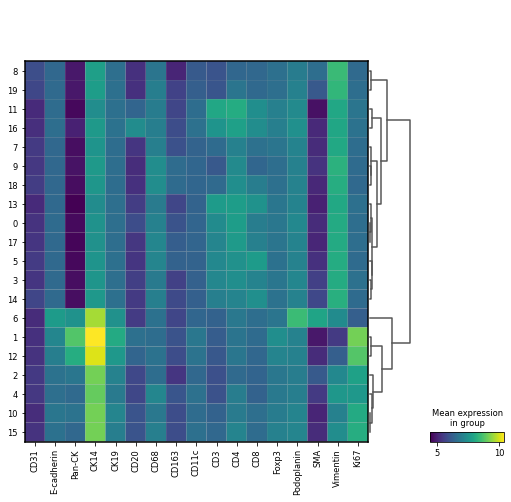

In [65]:
sc.pl.matrixplot(adata, var_names=adata.var.index, groupby='LDA_kmeans_cluster', dendrogram=True)

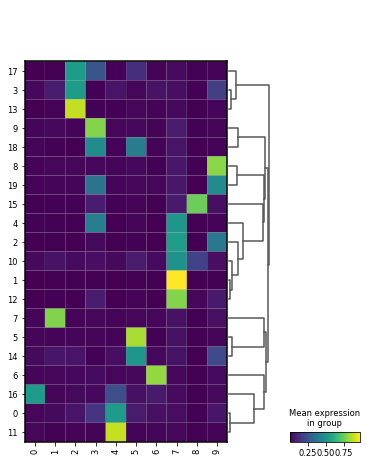

In [66]:
sc.pl.matrixplot(lda_adata, var_names=lda_adata.var.index, groupby='LDA_kmeans_cluster', dendrogram=True)

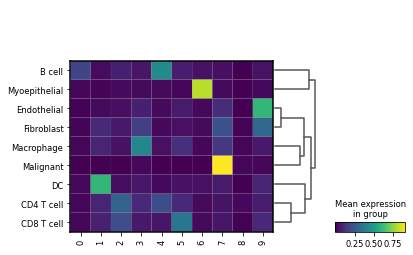

In [71]:
sc.pl.matrixplot(lda_adata, var_names=lda_adata.var.index, groupby='cell_type', dendrogram=True)

In [73]:
dictionary.get(0)

'Malignant'

<AxesSubplot:>

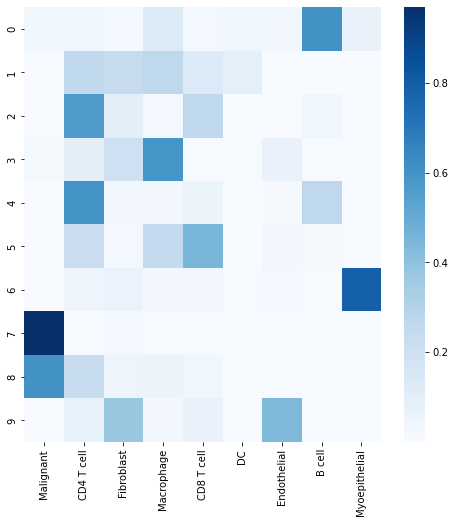

In [76]:
topic_df = pd.DataFrame(data=model.get_topics(), columns=[dictionary.get(i) for i in range(len(dictionary))],
                        index=np.arange(num_topics))
import seaborn as sns
sns.heatmap(topic_df, cmap='Blues')

In [68]:
plt.rcParams["figure.figsize"] = (8, 8)

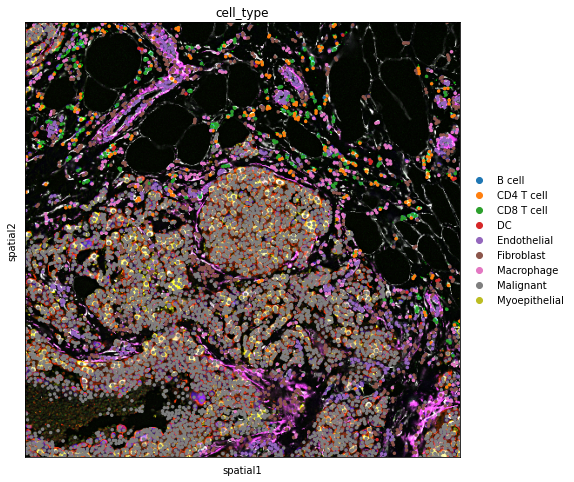

In [69]:
sc.pl.spatial(adata, color='cell_type', crop_coord=[5000, 7000, 5000, 7000], size=.8)

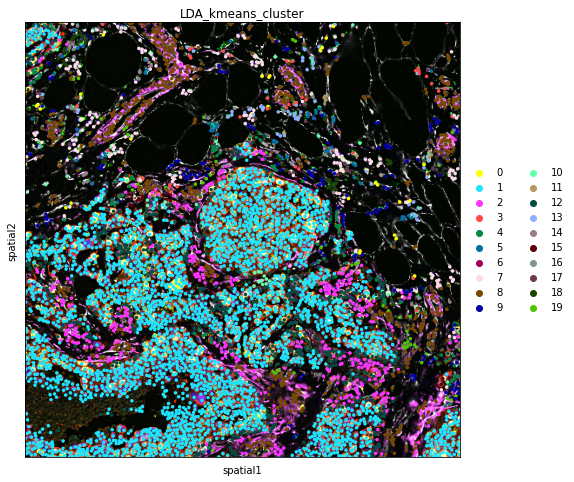

In [70]:
sc.pl.spatial(adata, color='LDA_kmeans_cluster', crop_coord=[5000, 7000, 5000, 7000], size=.8)

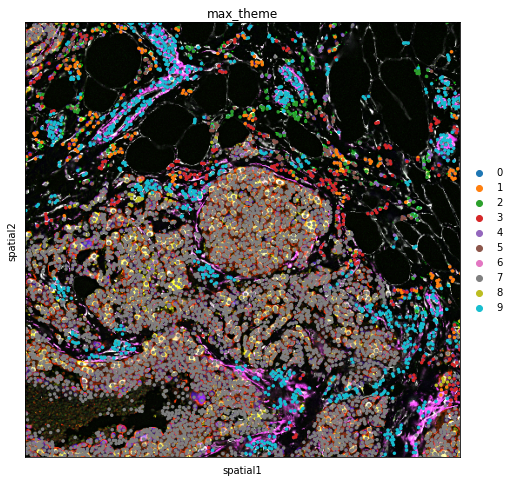

In [49]:
sc.pl.spatial(adata, color='max_theme', crop_coord=[5000, 7000, 5000, 7000], size=.8)

In [78]:
metacluster_to_cluster = {
    'Tumor - Pure': [1, 12, 10],
    'Tumor - Infiltrating Immune': [4],
    'Myoepithelium': [2, 15, 6],
    'Myoepithelium/Endothelial': [8, 19],
    'Immune - Macrophage': [9, 18],
    'Immune - T cell': [17, 3, 13],
    'Mixed Stroma': [7],
    'Immune - Mixed': [5, 14],
    'Immune - B cell': [16],
    'Immune - T/B cell': [0, 11]
}
cluster_to_metacluster = {str(v):k for k, vs in metacluster_to_cluster.items() for v in vs}
adata.obs['metacluster'] = [cluster_to_metacluster[c] for c in adata.obs['LDA_kmeans_cluster']]

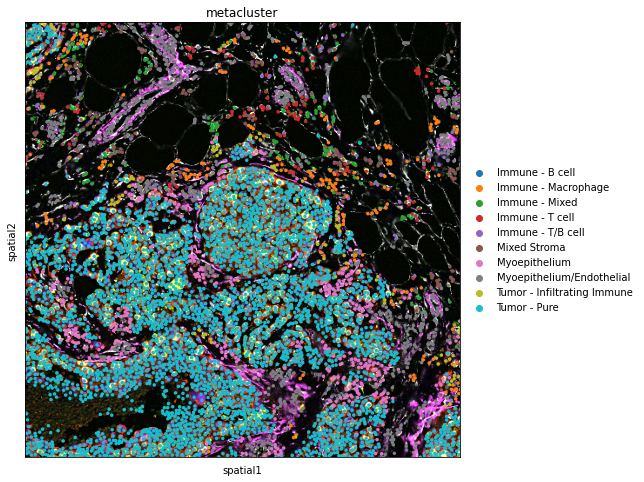

In [79]:
sc.pl.spatial(adata, color='metacluster', crop_coord=[5000, 7000, 5000, 7000], size=.8)

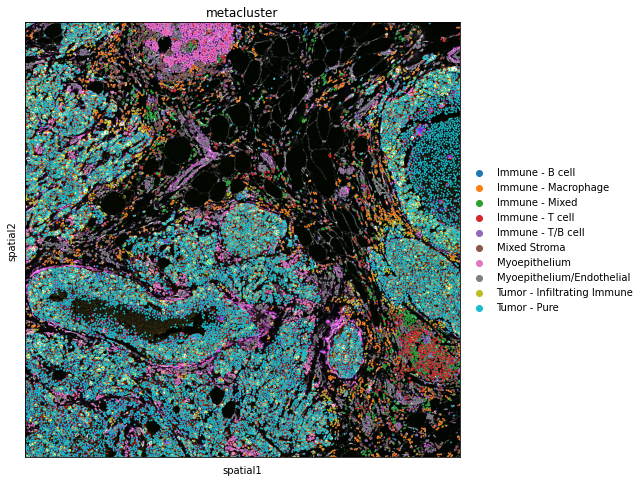

In [80]:
sc.pl.spatial(adata, color='metacluster', crop_coord=[4000, 8000, 4000, 8000], size=.8)

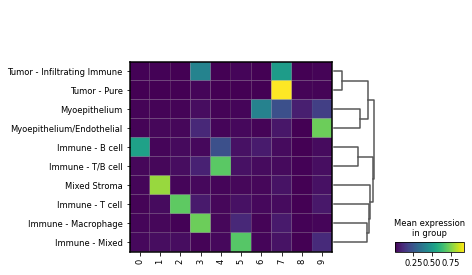

In [85]:
lda_adata.obs['metacluster'] = [cluster_to_metacluster[c] for c in lda_adata.obs['LDA_kmeans_cluster']]
sc.pl.matrixplot(lda_adata, var_names=lda_adata.var.index, groupby='metacluster', dendrogram=True)

In [81]:
adata.write_h5ad('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/downstream_analysis/neighborhood_analysis.h5ad')

###### visualization